# Install packages
AgenticTrader

In [1]:
%%capture --no-stderr
!pip install -q langchain_google_genai langchain_core langchain_community tavily-python pydantic
%pip install --quiet -U langgraph

# Import packages

In [2]:
from pydantic import BaseModel
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage

 # Set up authentication keys

In [3]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

In [4]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    api_key = GEMINI_API_KEY,
    temperature = 0)

In [5]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f43797de-4267-4808-80bd-df4d658152e2-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [6]:
messages = [
    HumanMessage(content="Hi", name="Human Student"),
    AIMessage(content='Hi! How can I help you today? \n', name="AI Assistant"),
    HumanMessage(content="What is LangChain?", name="Human Student"),
    AIMessage(content='LangChain is a framework for developing applications powered by language models.', name="AI Assistant"),
    HumanMessage(content="How can I learn", name="Human Student"),
    ]

response = llm.invoke(messages)
messages.append(response)

# for message in messages:
#   message.pretty_print()

# State

First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [7]:
class learning_state(BaseModel):
  prompt : str

In [8]:
# prompt: create an example from above LearningState
state: learning_state = learning_state(prompt = "hello from world")
print(state)
print(state.prompt +" I am")
print(state)
print(type(state))

prompt='hello from world'
hello from world I am
prompt='hello from world'
<class '__main__.learning_state'>


# Nodes

Nodes are just Python functions.

The first positional argument is the state (a Pydantic model).

Since the state is a Pydantic model, nodes can access fields like: state.graph_state.

Each node returns a new instance of the state with an updated graph_state value.

By default, this new value replaces the old one.

In [9]:
# For TypedDict

# def node_1(state: learning_state) -> learning_state:
#   print("---node 1 state ---")
#   return {"prompt" : state['prompt'] + "i am"}

# def node_2(state: learning_state) -> learning_state:
#   print("---node 2 state ---")
#   return {"prompt" : state['prompt'] + "happy"}

# For pydantic

def node_1(state: learning_state) -> learning_state:
    print("---node 1 state ---")
    return learning_state(prompt=state.prompt + " i am")

def node_2(state: learning_state) -> learning_state:
    print("---node 2 state ---")
    return learning_state(prompt=state.prompt + " happy")


# Edges
Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

# Graph Construction
Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

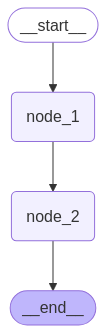

In [10]:
# Build graph
builder: StateGraph = StateGraph(state_schema=learning_state)

# Nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Simples Edges Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


# Graph Invocation
The compiled graph implements the runnable protocol.

This provides a standard way to execute LangChain components.

invoke is one of the standard methods in this interface.

The input is a dictionary {"graph_state": "Hi, this is lance."}, which sets the initial value for our graph state dict.

When invoke is called, the graph starts execution from the START node.

It progresses through the defined nodes (node_1, node_2, node_3) in order.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

In [11]:
graph.invoke({"prompt" : "Hi"})

---node 1 state ---
---node 2 state ---


{'prompt': 'Hi i am happy'}

# Conditional Edges
Conditional Edges are used want to optionally route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [12]:
class learning_state(BaseModel):
    prompt: str

def node_1(state: learning_state) -> learning_state:
    print("---node 1 state ---")
    return learning_state(prompt=state.prompt + " i am")

def node_2(state: learning_state) -> learning_state:
    print("---node 2 state ---")
    return learning_state(prompt=state.prompt + " happy")

def node_3(state: learning_state) -> learning_state:
    print("---node 3 state ---")
    return learning_state(prompt=state.prompt + " sad")

In [13]:
import random
from typing import Literal

def decide_mood(state: learning_state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state.prompt

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

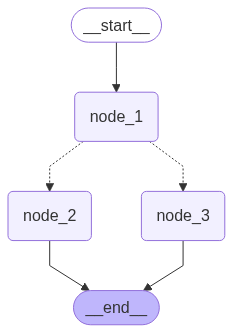

In [14]:
# Build Graph
builder : StateGraph = StateGraph(learning_state)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


graph : CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"prompt": "Hi, this is Lance."})

---node 1 state ---
---node 3 state ---


{'prompt': 'Hi, this is Lance. i am sad'}

# Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including HumanMessage, AIMessage, SystemMessage, and ToolMessage.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

content - content of the message
name - optionally, a message author
response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

# Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

In [16]:
def deposit_money(name: str, bank_account_no: int) -> int:
    """Deposit Money in Bank account.

    Args:
        name: first str
        bank_account_no: second int
    """
    # BUSINESS LOGIC for Bank Deposit
    # ......
    return {"status": f"Deposit Successfule in {name} Account"}

In [17]:
llm_with_tools = llm.bind_tools([deposit_money])

In [18]:
# Without tool call
call = llm.invoke([HumanMessage(content=f"Deposit Money in Ahmad Account. His acc number is 00123", name="Muhammad")])
call

AIMessage(content="Okay, I understand. You want to deposit money into Ahmad's account, and the account number is 00123.\n\n**Important Considerations:**\n\n*   **I am an AI and cannot perform real-world transactions.** I cannot actually deposit money into any account.\n*   **Security:** Never share sensitive financial information (like your own account numbers, passwords, or PINs) with me or any untrusted source.\n\n**To actually deposit the money, you will need to do one of the following:**\n\n1.  **Go to Ahmad's Bank:** Visit a branch of the bank where Ahmad has his account (00123). You can tell the teller you want to deposit money into account number 00123, belonging to Ahmad. You will likely need to provide the exact name on the account.\n2.  **Online Banking/Mobile App:** If you have an account at the same bank as Ahmad, you may be able to transfer funds to his account through your online banking portal or mobile app. You'll need to add him as a payee/recipient and use his account

In [19]:
# With tool call
call = llm_with_tools.invoke([HumanMessage(content=f"Deposit Money in Ahmad Account. His acc number is 00123", name="Muhammad")])
call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"name": "Ahmad", "bank_account_no": 123.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--2729f61c-d456-4288-952a-91b284e30f63-0', tool_calls=[{'name': 'deposit_money', 'args': {'name': 'Ahmad', 'bank_account_no': 123.0}, 'id': 'f1b34772-d350-4501-adb3-f81764a0d48a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 44, 'output_tokens': 11, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}})

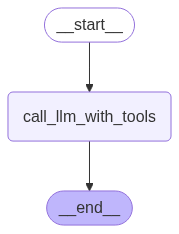

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"name": "Ahmad", "bank_account_no": 1.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--bf59ff56-c30a-454a-99ac-3a877ba9afa7-0', tool_calls=[{'name': 'deposit_money', 'args': {'name': 'Ahmad', 'bank_account_no': 1.0}, 'id': '41b65247-7d60-4ff1-8975-ad4404de2fdc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59, 'input_token_details': {'cache_read': 0}})]}

In [20]:
# Building Graph
# We have an LLM Capable of Tool Calling: using bind_tools

# Now Lets do the Orchestration Through LangGraph

# 0.  State

from typing_extensions import TypedDict

class LlmWithToolSState(TypedDict):
  messages: list

# 1. tool calling llm ki Node

def call_llm(state: LlmWithToolSState):
  messages = state["messages"]
  call_response = llm_with_tools.invoke(messages)
  # messages.append(call_response)

  # return {"messages": messages}
  return {"messages": [call_response]}

# 2. Graph

from langgraph.graph import StateGraph, START, END

builder: StateGraph = StateGraph(LlmWithToolSState)

# define nodes
builder.add_node("call_llm_with_tools", call_llm)

# define edges
builder.add_edge(START, "call_llm_with_tools")
builder.add_edge("call_llm_with_tools", END)

# build graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"messages": [HumanMessage(content="Deposiut 7000 in Ahmad Account - his bank num is 001")]})

# Current Flow
LLM: Call this Tool
System: Called Tool and told LLM the result.

# Issue ??: Where is my Human Message
Right now in response we only have AIMessage

# Solutions:
Proposal 1: manually Add Messages in call_llm using llm

Proposal 2: Reducer Functions to Keep History Context


# Chain

Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state

Using chat models in graph nodes

Binding tools to our chat model

Executing tool calls in graph nodes

# Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including HumanMessage, AIMessage, SystemMessage, and ToolMessage.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

content - content of the message

name - optionally, a message author

response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [21]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


# Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

# Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will will override the prior messages value.

As our graph runs, we want to append messages to to our messages state key.

We can use reducer functions address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our messages key with the add_messages reducer function as metadata.

In [23]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

Since having a list of messages in graph state is so common, LangGraph has a pre-built MessagesState!

MessagesState is defined:

- With a pre-build single messages key

- This is a list of AnyMessage objects

- It uses the add_messages reducer


In [24]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [25]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='54df1d08-a1c3-4758-bcad-f7375be0a444'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='38f668a7-7fee-47af-9d42-dc326fa156a3'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='57efbf85-aef4-4119-a8cf-1ecabd15a63f')]

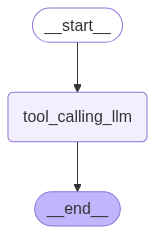

In [26]:
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph: CompiledStateGraph  = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I help you today?
